In [1]:
import tensorflow as tf
import numpy as np
from time import time
from datetime import datetime
import math
import matplotlib.pyplot as plt
from PIL import Image

USE_GPU = True

log = lambda *args: print(datetime.now().strftime('%H:%M:%S'), ':', *args)

def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test, mean_pixel, std_pixel


class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        assert X.shape[0] == y.shape[0]
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i + B], self.y[i:i + B]) for i in range(0, N, B))


X_train, y_train, X_val, y_val, X_test, y_test, mean_pixel, std_pixel = load_cifar10()
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

get_X_train_sample = lambda: next(iter(train_dset))[0][7] * std_pixel + mean_pixel

def select_device(use_gpu=True):
    from tensorflow.python.client import device_lib
    log(device_lib.list_local_devices())
    device = '/device:GPU:0' if use_gpu else '/CPU:0'
    log('Using device: ', device)
    return device

device = select_device(use_gpu=USE_GPU)


170500096/170498071 [==============================] - 52s 0us/step
21:38:42 : [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1510383238552638456
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8812598668720571750
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6500209139493391441
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10245685248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15046777467048287873
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
21:38:42 : Using device:  /device:GPU:0


In [0]:
def flatten(x):
    """
    Input:
    - TensorFlow Tensor of shape (N, D1, ..., DM)

    Output:
    - TensorFlow Tensor of shape (N, D1 * ... * DM)
    """
    x_flat = None

    x_flat = tf.reshape(x, (tf.shape(x)[0], -1))

    return x_flat


In [0]:
def kaiming_normal(shape):
    """
    He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on
    ImageNet Classification, ICCV 2015, https://arxiv.org/abs/1502.01852
    """
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.random_normal(shape) * np.sqrt(2.0 / fan_in)

In [0]:
def convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    """

    conv_w1 = tf.Variable(kaiming_normal([5, 5, 3, 32]))
    conv_b1 = tf.Variable(tf.zeros(32,))

    conv_w2 = tf.Variable(kaiming_normal([5, 5, 32, 32]))
    conv_b2 = tf.Variable(tf.zeros(32,))

    conv_w3 = tf.Variable(kaiming_normal([5, 5, 32, 64]))
    conv_b3 = tf.Variable(tf.zeros(64,))

    conv_w4, conv_b4, conv_w5, conv_b5 = tf.Variable(kaiming_normal([4, 4, 64, 64])),\
    tf.Variable(tf.zeros(64,)), tf.Variable(kaiming_normal([1, 1, 64, 10])), tf.Variable(tf.zeros(10,))

    params = [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3, conv_w4, conv_b4, conv_w5, conv_b5]

    return params

In [0]:
def convnet_forward(x, params):
    """
    A three-layer convolutional network.

    Args:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the network.
    """
    [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3, conv_w4, conv_b4, conv_w5, conv_b5] = params

    # block 1
    x1_1_pad = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_2_conv = tf.nn.conv2d(x1_1_pad, conv_w1, [1, 1, 1, 1], padding='VALID') + conv_b1
    x1_3_pad = tf.pad(x1_2_conv, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_4_pool = tf.nn.max_pool(x1_3_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    x1_5_relu = tf.nn.relu(x1_4_pool)

    # block 2
    x2_1_pad = tf.pad(x1_5_relu, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_2_conv = tf.nn.conv2d(x2_1_pad, conv_w2, [1, 1, 1, 1], padding='VALID') + conv_b2
    x2_3_relu = tf.nn.relu(x2_2_conv)
    x2_4_pad = tf.pad(x2_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_5_pool = tf.nn.avg_pool(x2_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # block 3
    x3_1_pad = tf.pad(x2_5_pool, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x3_2_conv = tf.nn.conv2d(x3_1_pad, conv_w3, [1, 1, 1, 1], padding='VALID') + conv_b3
    x3_3_relu = tf.nn.relu(x3_2_conv)
    x3_4_pad = tf.pad(x3_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x3_5_pool = tf.nn.avg_pool(x3_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # You may use padding=0

    # block 4
    x4_1_pad = tf.pad(x3_5_pool, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x4_2_conv = tf.nn.conv2d(x4_1_pad, conv_w4, [1, 1, 1, 1], padding='VALID') + conv_b4
    x4_3_relu = tf.nn.relu(x4_2_conv)
    x4_4_pad = tf.pad(x4_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x4_5_pool = tf.nn.max_pool(x4_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # block 5
    
    x5_1_conv = tf.nn.conv2d(x4_5_pool, conv_w5, [1, 1, 1, 1], padding='VALID') + conv_b5

    logits = flatten(x5_1_conv)

    return logits

In [0]:
def three_layer_convnet_test():
    tf.reset_default_graph()

    with tf.device(device):
        x = tf.placeholder(tf.float32)

        # block 1
        conv_w1 = tf.zeros([5, 5, 3, 32])
        conv_b1 = tf.zeros(32)

        # block 2
        conv_w2 = tf.zeros([5, 5, 32, 32])
        conv_b2 = tf.zeros(32)

        # block 3
        conv_w3 = tf.zeros([5, 5, 32, 64])
        conv_b3 = tf.zeros(64)

        conv_w4, conv_b4, conv_w5, conv_b5 = tf.Variable(tf.zeros([4, 4, 64, 64])), \
        tf.Variable(tf.zeros(64,)), tf.Variable(tf.zeros([1, 1, 64, 10])), tf.Variable(tf.zeros(10,))

        params = [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3, conv_w4, conv_b4, conv_w5, conv_b5]
        logits = convnet_forward(x, params)

    # Inputs to convolutional layers are 4-dimensional arrays with shape [batch_size, height, width, channels]
    x_np = np.zeros((64, 32, 32, 3))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        logits_np = sess.run(logits, feed_dict={x: x_np})
        log('logits_np has shape', format(logits_np.shape))


In [7]:
with tf.device('/cpu:0'):
    three_layer_convnet_test()

Instructions for updating:
Colocations handled automatically by placer.
21:38:43 : logits_np has shape (64, 90)


In [0]:
def training_step(logits, y, params, learning_rate):
    """
    Set up the part of the computational graph which makes a training step.

    Args:
    - logits: TensorFlow Tensor of shape (N, C) giving classification scores for
      the model.
    - y: TensorFlow Tensor of shape (N,) giving ground-truth labels for scores;
      y[i] == c means that c is the correct class for scores[i].
    - params: List of TensorFlow Tensors giving the weights of the model
    - learning_rate: Python scalar giving the learning rate to use for gradient
      descent step.

    Returns:
    - loss: A TensorFlow Tensor of shape () (scalar) giving the loss for this
      batch of data; evaluating the loss also performs a gradient descent step
      on params (see above).
    """
    # First compute the loss; the first line gives losses for each example in
    # the mini-batch, and the second averages the losses across the batch
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(losses)

    # Compute the gradient of the loss with respect to each parameter of the the
    # network. This is a very magical function call: TensorFlow internally
    # traverses the computational graph starting at loss backward to each element
    # of params, and uses back-propagation to figure out how to compute gradients;
    # it then adds new operations to the computational graph which compute the
    # requested gradients, and returns a list of TensorFlow Tensors that will
    # contain the requested gradients when evaluated.
    grad_params = tf.gradients(loss, params)

    # Make a gradient descent step on all of the model parameters.
    new_weights = []
    for w, grad_w in zip(params, grad_params):
        new_w = tf.assign_sub(w, learning_rate * grad_w)
        new_weights.append(new_w)

    # Insert a control dependency so that evaluating the loss causes a weight
    # update to happen.
    with tf.control_dependencies(new_weights):
        return tf.identity(loss)


def train(model_fn, init_fn, learning_rate, epochs, print_every=100):
    """
    Train a model on CIFAR-10.

    Args:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    # First clear the default graph
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    # Set up the computational graph for performing forward and backward passes,
    # and weight updates.
    with tf.device(device):
        # Set up placeholders for the data and labels
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        params = init_fn()  # Initialize the model parameters
        scores = model_fn(x, params)  # Forward pass of the model
        loss = training_step(scores, y, params, learning_rate)

    train_losses = []
    test_accuracies = []

    # Now we actually run the graph many times using the training data
    with tf.Session() as sess:
        # Initialize variables that will live in the graph
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            log('epoch {:>4d}/{:>4d}'.format(epoch, epochs))
            epoch_time = time()
            for t, (x_np, y_np) in enumerate(train_dset):
                # Run the graph on a batch of training data; recall that asking
                # TensorFlow to evaluate loss will cause an SGD step to happen.
                feed_dict = {x: x_np, y: y_np}
                loss_np = sess.run(loss, feed_dict=feed_dict)

                # Periodically print the loss and check accuracy on the val set
                if t % print_every == 0:
                    num_correct, num_samples, acc = get_accuracy(sess, val_dset, x, scores, is_training)
                    log('   iteration = {:>4d}, loss = {:>8.4f}, accuracy = {:>8.2f}%'.format(t, loss_np, acc))

            train_losses.append(loss_np)
            test_accuracies.append(acc)

            log('epoch {:>4d} took {:>.2f}s'.format(epoch, time()-epoch_time))

        return params, sess.run(params), train_losses, test_accuracies


def get_accuracy(sess, dset, x, logits, is_training=None):
    """
    Check accuracy on a classification model.

    Args:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.

    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(logits, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    return num_correct, num_samples, 100 * acc


21:38:43 : epoch    0/  10
21:38:43 :    iteration =    0, loss =   4.8043, accuracy =     6.20%
21:38:44 :    iteration =  100, loss =   2.1181, accuracy =    17.90%
21:38:45 :    iteration =  200, loss =   1.9051, accuracy =    27.70%
21:38:46 :    iteration =  300, loss =   2.0604, accuracy =    26.40%
21:38:47 :    iteration =  400, loss =   1.8386, accuracy =    32.70%
21:38:48 :    iteration =  500, loss =   1.7402, accuracy =    37.50%
21:38:49 :    iteration =  600, loss =   1.7177, accuracy =    39.50%
21:38:50 :    iteration =  700, loss =   1.5073, accuracy =    40.60%
21:38:51 : epoch    0 took 8.13s
21:38:51 : epoch    1/  10
21:38:51 :    iteration =    0, loss =   1.5770, accuracy =    41.20%
21:38:52 :    iteration =  100, loss =   1.5646, accuracy =    43.60%
21:38:53 :    iteration =  200, loss =   1.3261, accuracy =    46.20%
21:38:54 :    iteration =  300, loss =   1.5654, accuracy =    43.20%
21:38:55 :    iteration =  400, loss =   1.4902, accuracy =    50.50%
21:

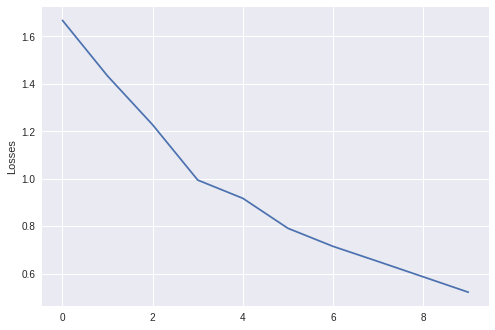

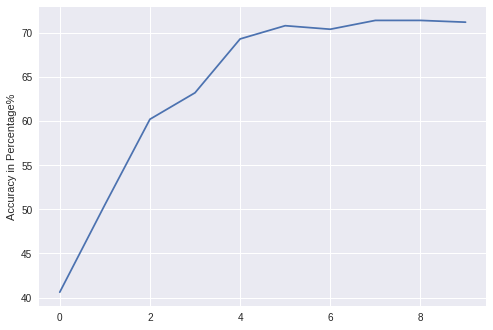

<Figure size 576x396 with 0 Axes>

In [9]:
learning_rate = 7e-2
epochs = 10

params, params_val, train_losses, test_accuracies = train(convnet_forward, convnet_init, learning_rate, epochs=epochs)

plt.plot(train_losses)
plt.ylabel('Losses')
plt.show()
plt.savefig('1_loss.png')
plt.plot(test_accuracies)
plt.ylabel('Accuracy in Percentage%')
plt.show()
plt.savefig('2_accuracy.png')


1 Block

In [0]:
def convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    """

    conv_w1 = tf.Variable(kaiming_normal([5, 5, 3, 32]))
    conv_b1 = tf.Variable(tf.zeros(32,))

    conv_w5, conv_b5 = tf.Variable(kaiming_normal([1, 1, 32, 10])), tf.Variable(tf.zeros(10,))

    params = [conv_w1, conv_b1, conv_w5, conv_b5]

    return params

def convnet_forward(x, params):
    """
    A three-layer convolutional network.

    Args:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the network.
    """
    [conv_w1, conv_b1, conv_w5, conv_b5] = params

    # block 1
    x1_1_pad = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_2_conv = tf.nn.conv2d(x1_1_pad, conv_w1, [1, 1, 1, 1], padding='VALID') + conv_b1
    x1_3_pad = tf.pad(x1_2_conv, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_4_pool = tf.nn.max_pool(x1_3_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    x1_5_relu = tf.nn.relu(x1_4_pool)

    # block 5
    
    x5_1_conv = tf.nn.conv2d(x1_5_relu, conv_w5, [1, 1, 1, 1], padding='VALID') + conv_b5

    logits = flatten(x5_1_conv)

    return logits



Block 1 and Block 2

In [0]:
def convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    """

    conv_w1 = tf.Variable(kaiming_normal([5, 5, 3, 32]))
    conv_b1 = tf.Variable(tf.zeros(32,))

    conv_w2 = tf.Variable(kaiming_normal([5, 5, 32, 32]))
    conv_b2 = tf.Variable(tf.zeros(32,))

    conv_w5, conv_b5 = tf.Variable(kaiming_normal([1, 1, 32, 10])), tf.Variable(tf.zeros(10,))

    params = [conv_w1, conv_b1, conv_w2, conv_b2, conv_w5, conv_b5]

    return params

def convnet_forward(x, params):
    """
    A three-layer convolutional network.

    Args:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the network.
    """
    [conv_w1, conv_b1, conv_w2, conv_b2, conv_w5, conv_b5] = params

    # block 1
    x1_1_pad = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_2_conv = tf.nn.conv2d(x1_1_pad, conv_w1, [1, 1, 1, 1], padding='VALID') + conv_b1
    x1_3_pad = tf.pad(x1_2_conv, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_4_pool = tf.nn.max_pool(x1_3_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    x1_5_relu = tf.nn.relu(x1_4_pool)

    # block 2
    x2_1_pad = tf.pad(x1_5_relu, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_2_conv = tf.nn.conv2d(x2_1_pad, conv_w2, [1, 1, 1, 1], padding='VALID') + conv_b2
    x2_3_relu = tf.nn.relu(x2_2_conv)
    x2_4_pad = tf.pad(x2_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_5_pool = tf.nn.avg_pool(x2_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # block 5
    
    x5_1_conv = tf.nn.conv2d(x2_5_pool, conv_w5, [1, 1, 1, 1], padding='VALID') + conv_b5

    logits = flatten(x5_1_conv)

    return logits

Block 1, Block 2 and Block 3

In [0]:
def convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    """

    conv_w1 = tf.Variable(kaiming_normal([5, 5, 3, 32]))
    conv_b1 = tf.Variable(tf.zeros(32,))

    conv_w2 = tf.Variable(kaiming_normal([5, 5, 32, 32]))
    conv_b2 = tf.Variable(tf.zeros(32,))

    conv_w3 = tf.Variable(kaiming_normal([5, 5, 32, 64]))
    conv_b3 = tf.Variable(tf.zeros(64,))

    conv_w5, conv_b5 = tf.Variable(kaiming_normal([1, 1, 64, 10])), tf.Variable(tf.zeros(10,))

    params = [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3, conv_w5, conv_b5]

    return params

def convnet_forward(x, params):
    """
    A three-layer convolutional network.

    Args:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the network.
    """
    [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3, conv_w5, conv_b5] = params

    # block 1
    x1_1_pad = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_2_conv = tf.nn.conv2d(x1_1_pad, conv_w1, [1, 1, 1, 1], padding='VALID') + conv_b1
    x1_3_pad = tf.pad(x1_2_conv, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x1_4_pool = tf.nn.max_pool(x1_3_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    x1_5_relu = tf.nn.relu(x1_4_pool)

    # block 2
    x2_1_pad = tf.pad(x1_5_relu, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_2_conv = tf.nn.conv2d(x2_1_pad, conv_w2, [1, 1, 1, 1], padding='VALID') + conv_b2
    x2_3_relu = tf.nn.relu(x2_2_conv)
    x2_4_pad = tf.pad(x2_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x2_5_pool = tf.nn.avg_pool(x2_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # block 3
    x3_1_pad = tf.pad(x2_5_pool, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    x3_2_conv = tf.nn.conv2d(x3_1_pad, conv_w3, [1, 1, 1, 1], padding='VALID') + conv_b3
    x3_3_relu = tf.nn.relu(x3_2_conv)
    x3_4_pad = tf.pad(x3_3_relu, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT', constant_values=0)
    x3_5_pool = tf.nn.avg_pool(x3_4_pad, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # block 5
    
    x5_1_conv = tf.nn.conv2d(x3_5_pool, conv_w5, [1, 1, 1, 1], padding='VALID') + conv_b5

    logits = flatten(x5_1_conv)

    return logits

Part 2

In [13]:
def plot_kernels_on_grid(kernel, grid_Y, grid_X, pad = 1):
    """
    Visualize convolutional features as an image.

    Args:
      kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
      (grid_Y, grid_X):  shape of the grid. Require: NumKernels == grid_Y * grid_X
                           User is responsible of how to break into two multiples.
      pad:               number of black pixels around each filter (between them)

    Return:
      Tensor of shape [(Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels, 1].
    """

    x_min = tf.reduce_min(kernel)
    x_max = tf.reduce_max(kernel)

    kernel1 = (kernel - x_min) / (x_max - x_min)

    # pad X and Y
    x1 = tf.pad(kernel1, tf.constant([[pad,pad], [pad, pad], [0,0], [0,0]]), mode='CONSTANT')

    # X and Y dimensions, w.r.t. padding
    Y = kernel1.get_shape()[0] + 2 * pad
    X = kernel1.get_shape()[1] + 2 * pad

    channels = kernel1.get_shape()[2]

    # put NumKernels to the 1st dimension
    x2 = tf.transpose(x1, (3, 0, 1, 2))
    # organize grid on Y axis
    x3 = tf.reshape(x2, tf.stack([grid_X, Y * grid_Y, X, channels]))

    # switch X and Y axes
    x4 = tf.transpose(x3, (0, 2, 1, 3))
    # organize grid on X axis
    x5 = tf.reshape(x4, tf.stack([1, X * grid_X, Y * grid_Y, channels]))

    # back to normal order (not combining with the next step for clarity)
    x6 = tf.transpose(x5, (2, 1, 3, 0))

    # to tf.image_summary order [batch_size, height, width, channels], where in this case batch_size == 1
    x7 = tf.transpose(x6, (3, 0, 1, 2))

    # scale to [0, 255] and convert to uint8
    return tf.image.convert_image_dtype(x7, dtype=tf.uint8)


grid = plot_kernels_on_grid(params[0], 4, 8)

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)
    grid_val = grid.eval(session=sess)
    
    img = Image.fromarray(grid_val[0], 'RGB')
    display(img)
    img.save('3_kernels.jpeg')
    

Part 3

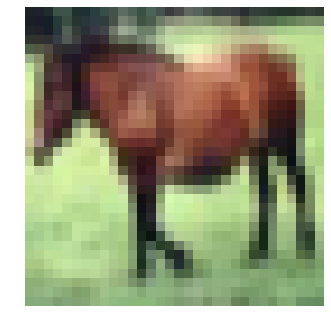

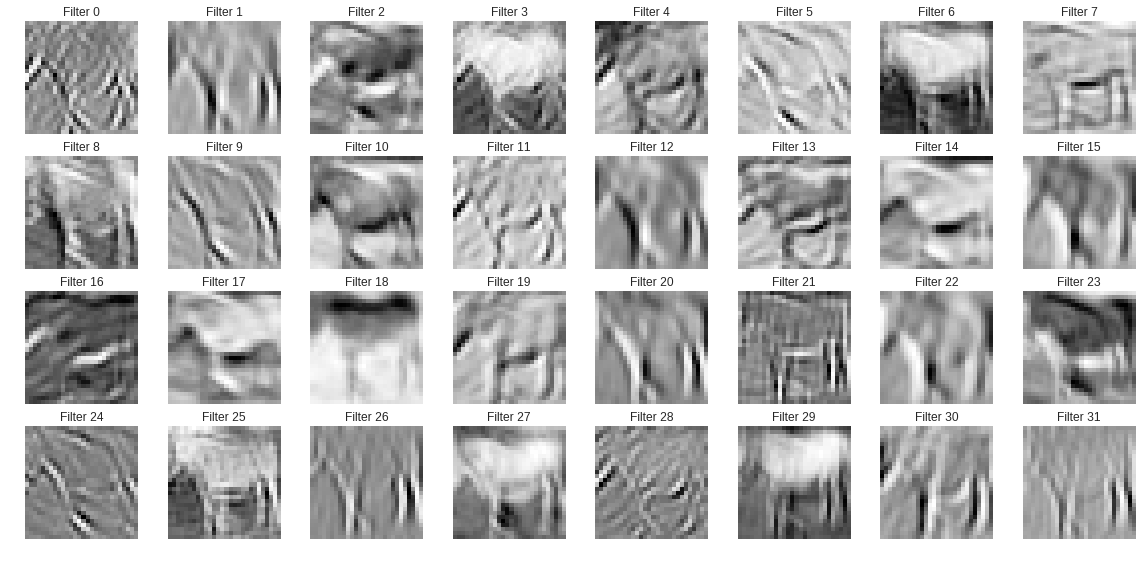

21:40:05 : done.


In [14]:
def plot_filter_grid(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20, 12))
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.axis('off')
        plt.imshow(units[0, :, :, i], interpolation='nearest')


def conv1_activations(x, conv_w1, conv_b1):
    output = None
    
    output = tf.nn.conv2d(x, conv_w1, [1, 1, 1, 1], padding='VALID') + conv_b1
    
    return output


image = get_X_train_sample()
plt.imshow(np.squeeze(image).astype(np.uint8), interpolation='nearest')
plt.figure(1, figsize=(10, 10))
plt.axis('off')
plt.savefig('4_data.png', bbox_inches='tight')
plt.show()

with tf.Session() as sess:
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    hidden_1 = sess.run(conv1_activations(x, params[0], params[1]), feed_dict={x: image, params[0]: params_val[0], params[1]: params_val[1]})
    plot_filter_grid(hidden_1)
    plt.savefig('5_activations.png', bbox_inches='tight')
    plt.show()

log('done.')



